# **Ordinary Least Squares**

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit([[0, 0], [1, 1], [2, 2]], [0, 1, 2])

reg.coef_

array([0.5, 0.5])

# **Ridge Regression and Classification**

In [ ]:
# REGRESSION
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.5)
reg.fit([[0, 0], [0, 0], [1, 1]], [0, .1, 1])

reg.coef_

reg.intercept_

In [ ]:
# CLASSIFICATION
# classification of text documents using sparse features

# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

op = OptionParser()
op.add_option(
    "--report",
    action="store_true",
    dest="print_report",
    help="Print a detailed classification report.",
)
op.add_option(
    "--chi2_select",
    action="store",
    type="int",
    dest="select_chi2",
    help="Select some number of features using a chi-squared test",
)
op.add_option(
    "--confusion_matrix",
    action="store_true",
    dest="print_cm",
    help="Print the confusion matrix.",
)
op.add_option(
    "--top10",
    action="store_true",
    dest="print_top10",
    help="Print ten most discriminative terms per class for every classifier.",
)
op.add_option(
    "--all_categories",
    action="store_true",
    dest="all_categories",
    help="Whether to use all categories or not.",
)
op.add_option("--use_hashing", action="store_true", help="Use a hashing vectorizer.")
op.add_option(
    "--n_features",
    action="store",
    type=int,
    default=2 ** 16,
    help="n_features when using the hashing vectorizer.",
)
op.add_option(
    "--filtered",
    action="store_true",
    help=(
        "Remove newsgroup information that is easily overfit: "
        "headers, signatures, and quoting."
    ),
)


def is_interactive():
    return not hasattr(sys.modules["__main__"], "__file__")


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.



In [ ]:
# setting the regularization parameter: leave-one-out Cross-Validation
import numpy as np
from sklearn import linear_model
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg.fit([[0, 0], [0, 0], [1, 1]], [0, .1, 1])


reg.alpha_

0.01

# **Lasso**

In [ ]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.1)
reg.fit([[0, 0], [1, 1]], [0, 1])

reg.predict([[1, 1]])

array([0.8])

Computing regularization path using the coordinate descent lasso...
Computing regularization path using the Lars lasso...


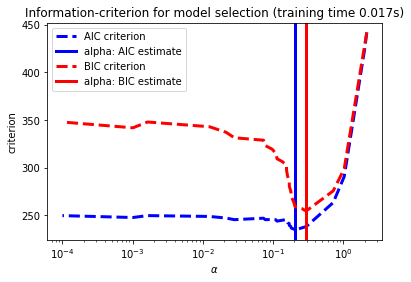

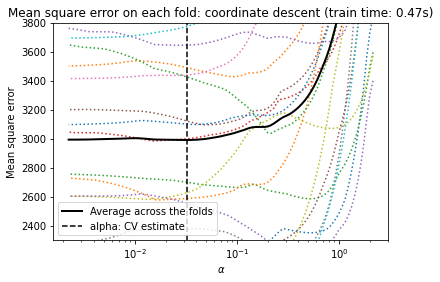

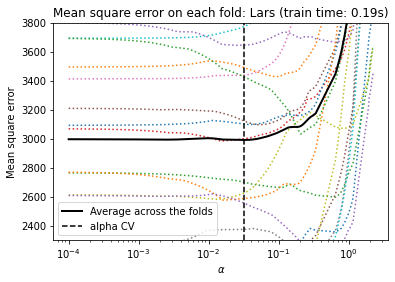

In [ ]:
# Lasso model selection: Cross-Validation / AIC / BIC

# Author: Olivier Grisel, Gael Varoquaux, Alexandre Gramfort
# License: BSD 3 clause

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn import datasets

# This is to avoid division by zero while doing np.log10
EPSILON = 1e-4

X, y = datasets.load_diabetes(return_X_y=True)

rng = np.random.RandomState(42)
X = np.c_[X, rng.randn(X.shape[0], 14)]  # add some bad features

# normalize data as done by Lars to allow for comparison
X /= np.sqrt(np.sum(X ** 2, axis=0))

# #############################################################################
# LassoLarsIC: least angle regression with BIC/AIC criterion

model_bic = LassoLarsIC(criterion="bic", normalize=False)
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion="aic", normalize=False)
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(
        model.alphas_ + EPSILON,
        criterion_,
        "--",
        color=color,
        linewidth=3,
        label="%s criterion" % name,
    )
    plt.axvline(
        model.alpha_ + EPSILON,
        color=color,
        linewidth=3,
        label="alpha: %s estimate" % name,
    )
    plt.xlabel(r"$\alpha$")
    plt.ylabel("criterion")


plt.figure()
plot_ic_criterion(model_aic, "AIC", "b")
plot_ic_criterion(model_bic, "BIC", "r")
plt.legend()
plt.title("Information-criterion for model selection (training time %.3fs)" % t_bic)

# #############################################################################
# LassoCV: coordinate descent

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=20).fit(X, y)
t_lasso_cv = time.time() - t1

# Display results
plt.figure()
ymin, ymax = 2300, 3800
plt.semilogx(model.alphas_ + EPSILON, model.mse_path_, ":")
plt.plot(
    model.alphas_ + EPSILON,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_ + EPSILON, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.title(
    "Mean square error on each fold: coordinate descent (train time: %.2fs)"
    % t_lasso_cv
)
plt.axis("tight")
plt.ylim(ymin, ymax)

# #############################################################################
# LassoLarsCV: least angle regression

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = LassoLarsCV(cv=20, normalize=False).fit(X, y)
t_lasso_lars_cv = time.time() - t1

# Display results
plt.figure()
plt.semilogx(model.cv_alphas_ + EPSILON, model.mse_path_, ":")
plt.semilogx(
    model.cv_alphas_ + EPSILON,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(model.alpha_, linestyle="--", color="k", label="alpha CV")
plt.legend()

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold: Lars (train time: %.2fs)" % t_lasso_lars_cv)
plt.axis("tight")
plt.ylim(ymin, ymax)

plt.show()

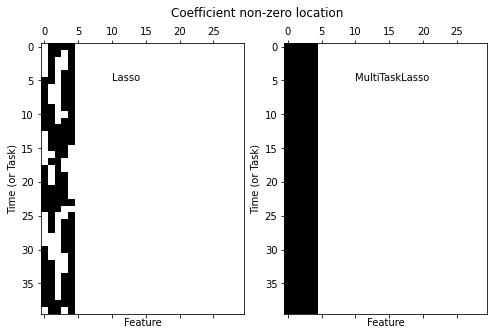

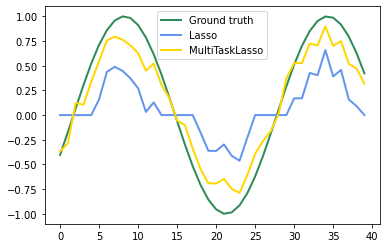

In [ ]:
# Joint feature selection with multi-task Lasso

# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import MultiTaskLasso, Lasso

rng = np.random.RandomState(42)

# Generate some 2D coefficients with sine waves with random frequency and phase
n_samples, n_features, n_tasks = 100, 30, 40
n_relevant_features = 5
coef = np.zeros((n_tasks, n_features))
times = np.linspace(0, 2 * np.pi, n_tasks)
for k in range(n_relevant_features):
    coef[:, k] = np.sin((1.0 + rng.randn(1)) * times + 3 * rng.randn(1))

X = rng.randn(n_samples, n_features)
Y = np.dot(X, coef.T) + rng.randn(n_samples, n_tasks)

coef_lasso_ = np.array([Lasso(alpha=0.5).fit(X, y).coef_ for y in Y.T])
coef_multi_task_lasso_ = MultiTaskLasso(alpha=1.0).fit(X, Y).coef_

# #############################################################################
# Plot support and time series
fig = plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.spy(coef_lasso_)
plt.xlabel("Feature")
plt.ylabel("Time (or Task)")
plt.text(10, 5, "Lasso")
plt.subplot(1, 2, 2)
plt.spy(coef_multi_task_lasso_)
plt.xlabel("Feature")
plt.ylabel("Time (or Task)")
plt.text(10, 5, "MultiTaskLasso")
fig.suptitle("Coefficient non-zero location")

feature_to_plot = 0
plt.figure()
lw = 2
plt.plot(coef[:, feature_to_plot], color="seagreen", linewidth=lw, label="Ground truth")
plt.plot(
    coef_lasso_[:, feature_to_plot], color="cornflowerblue", linewidth=lw, label="Lasso"
)
plt.plot(
    coef_multi_task_lasso_[:, feature_to_plot],
    color="gold",
    linewidth=lw,
    label="MultiTaskLasso",
)
plt.legend(loc="upper center")
plt.axis("tight")
plt.ylim([-1.1, 1.1])
plt.show()

# **Elastic Net**

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


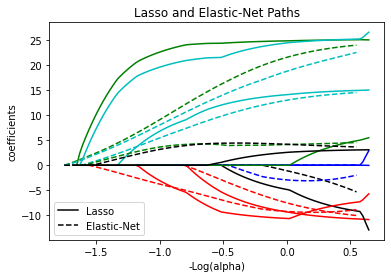

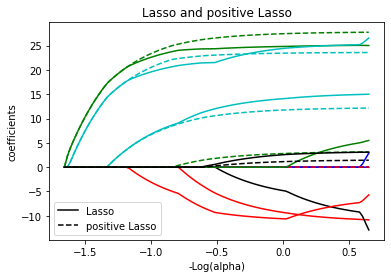

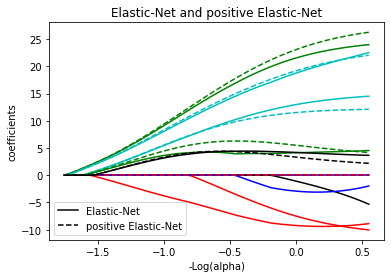

In [ ]:
# Lasso and Elastic Net

# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets


X, y = datasets.load_diabetes(return_X_y=True)


X /= X.std(axis=0)  # Standardize data (easier to set the l1_ratio parameter)

# Compute paths

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    X, y, eps=eps, positive=True
)
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=0.8)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, positive=True
)

# Display results

plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle="--", c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso and Elastic-Net Paths")
plt.legend((l1[-1], l2[-1]), ("Lasso", "Elastic-Net"), loc="lower left")
plt.axis("tight")


plt.figure(2)
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle="--", c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso and positive Lasso")
plt.legend((l1[-1], l2[-1]), ("Lasso", "positive Lasso"), loc="lower left")
plt.axis("tight")


plt.figure(3)
neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
    l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle="--", c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Elastic-Net and positive Elastic-Net")
plt.legend((l1[-1], l2[-1]), ("Elastic-Net", "positive Elastic-Net"), loc="lower left")
plt.axis("tight")
plt.show()

**Multi Task Elastic Net**

The MultiTaskElasticNet is an elastic-net model that estimates sparse coefficients for multiple regression problems jointly: Y is a 2D array of shape (n_samples, n_tasks). The constraint is that the selected features are the same for all the regression problems, also called tasks.

Mathematically, it consists of a linear model trained with a mixed 
 
-norm and 
-norm for regularization. The objective function to minimize is:

 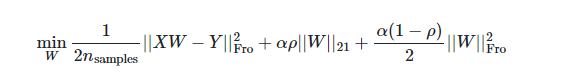
 
 
The implementation in the class MultiTaskElasticNet uses coordinate descent as the algorithm to fit the coefficients.

The class MultiTaskElasticNetCV can be used to set the parameters alpha () and l1_ratio () by cross-validation.

# **LARS Lasso**

Lasso Lars is a lasso model implemented using the LARS algorithm, and unlike the implementation based on coordinate descent, this yields the exact solution, which is piecewise linear as a function of the norm of its coefficients.

In [ ]:
from sklearn import linear_model
reg = linear_model.LassoLars(alpha=.1, normalize=False)
reg.fit([[0, 0], [1, 1]], [0, 1])

reg.coef_

array([0.6, 0. ])

Computing regularization path using the LARS ...
.

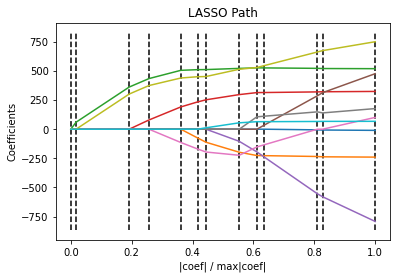

In [ ]:
# Lasso path using LARS

# Author: Fabian Pedregosa <fabian.pedregosa@inria.fr>
#         Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import datasets

X, y = datasets.load_diabetes(return_X_y=True)

print("Computing regularization path using the LARS ...")
_, _, coefs = linear_model.lars_path(X, y, method="lasso", verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle="dashed")
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.title("LASSO Path")
plt.axis("tight")
plt.show()

# **Orthogonal Matching Pursuit (OMP)**

Orthogonal Matching Pursuit and orthogonal_mp implements the OMP algorithm for approximating the fit of a linear model with constraints imposed on the number of non-zero coefficients (ie. the 
 pseudo-norm).

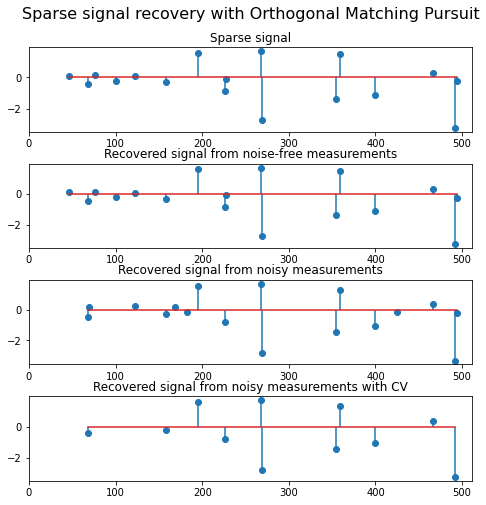

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal

n_components, n_features = 512, 100
n_nonzero_coefs = 17

# generate the data

# y = Xw
# |x|_0 = n_nonzero_coefs

y, X, w = make_sparse_coded_signal(
    n_samples=1,
    n_components=n_components,
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    random_state=0,
)

(idx,) = w.nonzero()

# distort the clean signal
y_noisy = y + 0.05 * np.random.randn(len(y))

# plot the sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(4, 1, 1)
plt.xlim(0, 512)
plt.title("Sparse signal")
plt.stem(idx, w[idx], use_line_collection=True)

# plot the noise-free reconstruction
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs, normalize=False)
omp.fit(X, y)
coef = omp.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 2)
plt.xlim(0, 512)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

# plot the noisy reconstruction
omp.fit(X, y_noisy)
coef = omp.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 3)
plt.xlim(0, 512)
plt.title("Recovered signal from noisy measurements")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

# plot the noisy reconstruction with number of non-zeros set by CV
omp_cv = OrthogonalMatchingPursuitCV(normalize=False)
omp_cv.fit(X, y_noisy)
coef = omp_cv.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 4)
plt.xlim(0, 512)
plt.title("Recovered signal from noisy measurements with CV")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

plt.subplots_adjust(0.06, 0.04, 0.94, 0.90, 0.20, 0.38)
plt.suptitle("Sparse signal recovery with Orthogonal Matching Pursuit", fontsize=16)
plt.show()

# **Bayesian Regression**

Bayesian regression techniques can be used to include regularization parameters in the estimation procedure: the regularization parameter is not set in a hard sense but tuned to the data at hand.



**Bayesian Ridge Regression**

Bayesian Ridge estimates a probabilistic model of the regression problem as described above.

In [ ]:

from sklearn import linear_model
X = [[0., 0.], [1., 1.], [2., 2.], [3., 3.]]
Y = [0., 1., 2., 3.]
reg = linear_model.BayesianRidge()
reg.fit(X, Y)


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

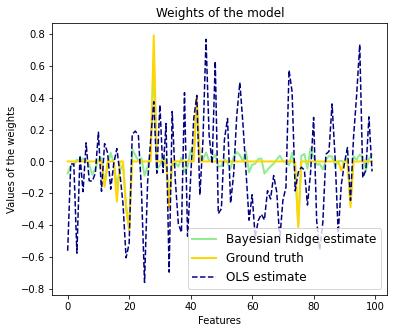

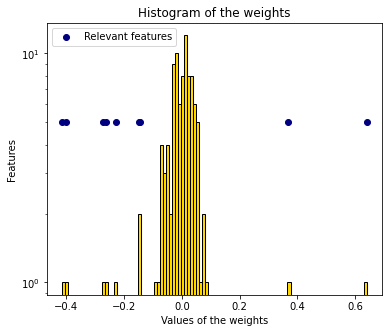

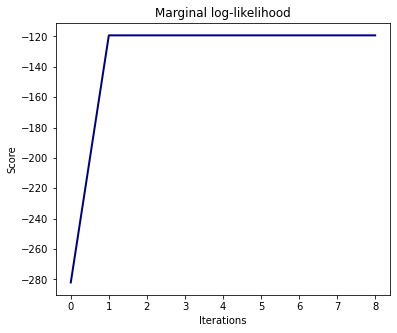

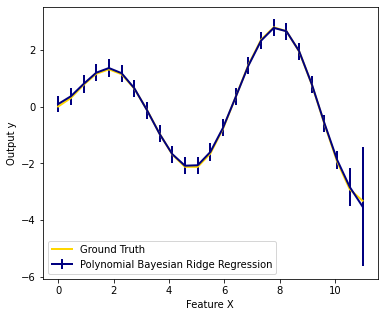

In [ ]:
# Example Bayesian Ridge Regression

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.linear_model import BayesianRidge, LinearRegression

# #############################################################################
# Generating simulated data with Gaussian weights
np.random.seed(0)
n_samples, n_features = 100, 100
X = np.random.randn(n_samples, n_features)  # Create Gaussian data
# Create weights with a precision lambda_ of 4.
lambda_ = 4.0
w = np.zeros(n_features)
# Only keep 10 weights of interest
relevant_features = np.random.randint(0, n_features, 10)
for i in relevant_features:
    w[i] = stats.norm.rvs(loc=0, scale=1.0 / np.sqrt(lambda_))
# Create noise with a precision alpha of 50.
alpha_ = 50.0
noise = stats.norm.rvs(loc=0, scale=1.0 / np.sqrt(alpha_), size=n_samples)
# Create the target
y = np.dot(X, w) + noise

# #############################################################################
# Fit the Bayesian Ridge Regression and an OLS for comparison
clf = BayesianRidge(compute_score=True)
clf.fit(X, y)

ols = LinearRegression()
ols.fit(X, y)

# #############################################################################
# Plot true weights, estimated weights, histogram of the weights, and
# predictions with standard deviations
lw = 2
plt.figure(figsize=(6, 5))
plt.title("Weights of the model")
plt.plot(clf.coef_, color="lightgreen", linewidth=lw, label="Bayesian Ridge estimate")
plt.plot(w, color="gold", linewidth=lw, label="Ground truth")
plt.plot(ols.coef_, color="navy", linestyle="--", label="OLS estimate")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc="best", prop=dict(size=12))

plt.figure(figsize=(6, 5))
plt.title("Histogram of the weights")
plt.hist(clf.coef_, bins=n_features, color="gold", log=True, edgecolor="black")
plt.scatter(
    clf.coef_[relevant_features],
    np.full(len(relevant_features), 5.0),
    color="navy",
    label="Relevant features",
)
plt.ylabel("Features")
plt.xlabel("Values of the weights")
plt.legend(loc="upper left")

plt.figure(figsize=(6, 5))
plt.title("Marginal log-likelihood")
plt.plot(clf.scores_, color="navy", linewidth=lw)
plt.ylabel("Score")
plt.xlabel("Iterations")


# Plotting some predictions for polynomial regression
def f(x, noise_amount):
    y = np.sqrt(x) * np.sin(x)
    noise = np.random.normal(0, 1, len(x))
    return y + noise_amount * noise


degree = 10
X = np.linspace(0, 10, 100)
y = f(X, noise_amount=0.1)
clf_poly = BayesianRidge()
clf_poly.fit(np.vander(X, degree), y)

X_plot = np.linspace(0, 11, 25)
y_plot = f(X_plot, noise_amount=0)
y_mean, y_std = clf_poly.predict(np.vander(X_plot, degree), return_std=True)
plt.figure(figsize=(6, 5))
plt.errorbar(
    X_plot,
    y_mean,
    y_std,
    color="navy",
    label="Polynomial Bayesian Ridge Regression",
    linewidth=lw,
)
plt.plot(X_plot, y_plot, color="gold", linewidth=lw, label="Ground Truth")
plt.ylabel("Output y")
plt.xlabel("Feature X")
plt.legend(loc="lower left")
plt.show()

# **Automatic Relevance Determination (ARD)**

ARD Regression is very similar to Bayesian Ridge Regression, but can lead to sparser coefficients ω. ARD Regression poses a different prior over ω, by dropping the assumption of the Gaussian being spherical.




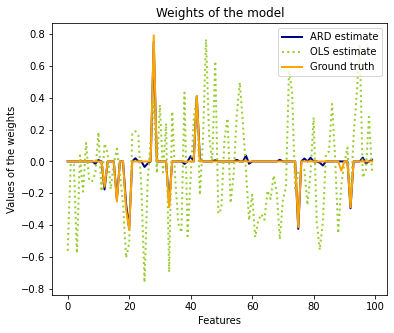

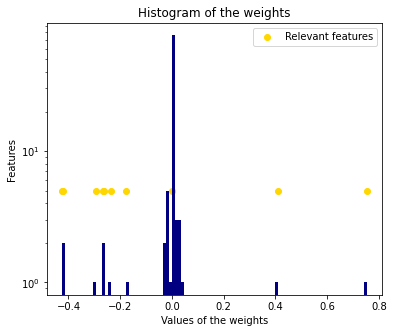

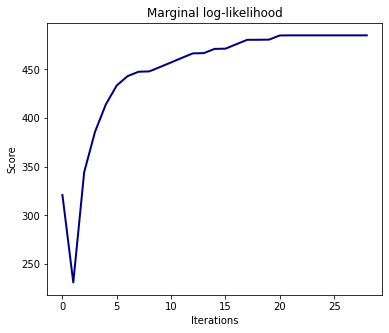

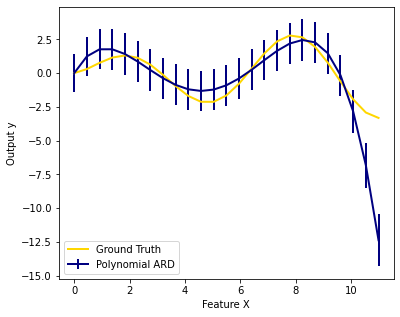

In [ ]:
# Example of ARD Regression

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.linear_model import ARDRegression, LinearRegression

# #############################################################################
# Generating simulated data with Gaussian weights

# Parameters of the example
np.random.seed(0)
n_samples, n_features = 100, 100
# Create Gaussian data
X = np.random.randn(n_samples, n_features)
# Create weights with a precision lambda_ of 4.
lambda_ = 4.0
w = np.zeros(n_features)
# Only keep 10 weights of interest
relevant_features = np.random.randint(0, n_features, 10)
for i in relevant_features:
    w[i] = stats.norm.rvs(loc=0, scale=1.0 / np.sqrt(lambda_))
# Create noise with a precision alpha of 50.
alpha_ = 50.0
noise = stats.norm.rvs(loc=0, scale=1.0 / np.sqrt(alpha_), size=n_samples)
# Create the target
y = np.dot(X, w) + noise

# #############################################################################
# Fit the ARD Regression
clf = ARDRegression(compute_score=True)
clf.fit(X, y)

ols = LinearRegression()
ols.fit(X, y)

# #############################################################################
# Plot the true weights, the estimated weights, the histogram of the
# weights, and predictions with standard deviations
plt.figure(figsize=(6, 5))
plt.title("Weights of the model")
plt.plot(clf.coef_, color="darkblue", linestyle="-", linewidth=2, label="ARD estimate")
plt.plot(
    ols.coef_, color="yellowgreen", linestyle=":", linewidth=2, label="OLS estimate"
)
plt.plot(w, color="orange", linestyle="-", linewidth=2, label="Ground truth")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc=1)

plt.figure(figsize=(6, 5))
plt.title("Histogram of the weights")
plt.hist(clf.coef_, bins=n_features, color="navy", log=True)
plt.scatter(
    clf.coef_[relevant_features],
    np.full(len(relevant_features), 5.0),
    color="gold",
    marker="o",
    label="Relevant features",
)
plt.ylabel("Features")
plt.xlabel("Values of the weights")
plt.legend(loc=1)

plt.figure(figsize=(6, 5))
plt.title("Marginal log-likelihood")
plt.plot(clf.scores_, color="navy", linewidth=2)
plt.ylabel("Score")
plt.xlabel("Iterations")


# Plotting some predictions for polynomial regression
def f(x, noise_amount):
    y = np.sqrt(x) * np.sin(x)
    noise = np.random.normal(0, 1, len(x))
    return y + noise_amount * noise


degree = 10
X = np.linspace(0, 10, 100)
y = f(X, noise_amount=1)
clf_poly = ARDRegression(threshold_lambda=1e5)
clf_poly.fit(np.vander(X, degree), y)

X_plot = np.linspace(0, 11, 25)
y_plot = f(X_plot, noise_amount=0)
y_mean, y_std = clf_poly.predict(np.vander(X_plot, degree), return_std=True)
plt.figure(figsize=(6, 5))
plt.errorbar(X_plot, y_mean, y_std, color="navy", label="Polynomial ARD", linewidth=2)
plt.plot(X_plot, y_plot, color="gold", linewidth=2, label="Ground Truth")
plt.ylabel("Output y")
plt.xlabel("Feature X")
plt.legend(loc="lower left")
plt.show()

# **Logistic regression**

Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

Computing regularization path ...
This took 0.059s


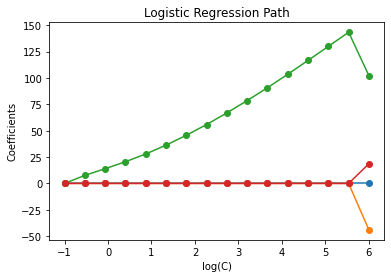

In [ ]:
# Example
# Regularization path of L1- Logistic Regression

# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import datasets
from sklearn.svm import l1_min_c

iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[y != 2]
y = y[y != 2]

X /= X.max()  # Normalize X to speed-up convergence


# Demo path functions

cs = l1_min_c(X, y, loss="log") * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-6,
    max_iter=int(1e6),
    warm_start=True,
    intercept_scaling=10000.0,
)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_, marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.show()

# **Stochastic Gradient Descent (SGD)**

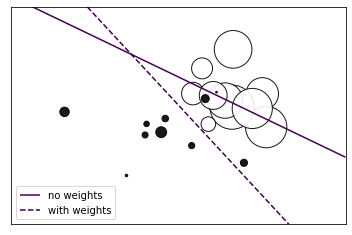

In [ ]:
# Example
# Weighted Samples

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10
sample_weight = 100 * np.abs(np.random.randn(20))
# and assign a bigger weight to the last 10 samples
sample_weight[:10] *= 10

# plot the weighted data points
xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))
plt.figure()
plt.scatter(
    X[:, 0],
    X[:, 1],
    c=y,
    s=sample_weight,
    alpha=0.9,
    cmap=plt.cm.bone,
    edgecolor="black",
)

# fit the unweighted model
clf = linear_model.SGDClassifier(alpha=0.01, max_iter=100)
clf.fit(X, y)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
no_weights = plt.contour(xx, yy, Z, levels=[0], linestyles=["solid"])

# fit the weighted model
clf = linear_model.SGDClassifier(alpha=0.01, max_iter=100)
clf.fit(X, y, sample_weight=sample_weight)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
samples_weights = plt.contour(xx, yy, Z, levels=[0], linestyles=["dashed"])

plt.legend(
    [no_weights.collections[0], samples_weights.collections[0]],
    ["no weights", "with weights"],
    loc="lower left",
)

plt.xticks(())
plt.yticks(())
plt.show()

# **Quantile regression**

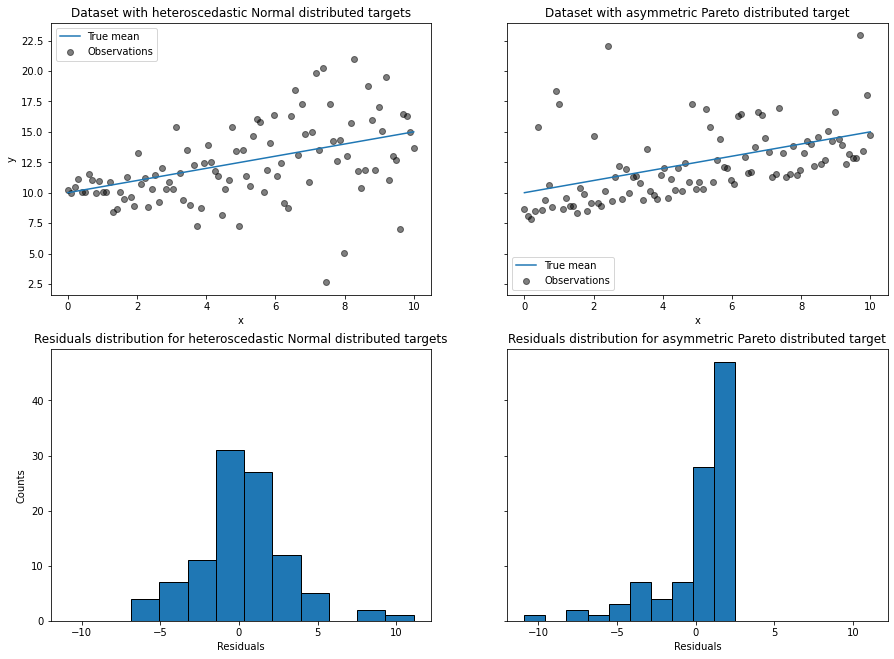

In [ ]:
# Dataset generation

import numpy as np

rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x

y_normal = y_true_mean + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])
a = 5
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))

import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11), sharex="row", sharey="row")

axs[0, 0].plot(x, y_true_mean, label="True mean")
axs[0, 0].scatter(x, y_normal, color="black", alpha=0.5, label="Observations")
axs[1, 0].hist(y_true_mean - y_normal, edgecolor="black")


axs[0, 1].plot(x, y_true_mean, label="True mean")
axs[0, 1].scatter(x, y_pareto, color="black", alpha=0.5, label="Observations")
axs[1, 1].hist(y_true_mean - y_pareto, edgecolor="black")

axs[0, 0].set_title("Dataset with heteroscedastic Normal distributed targets")
axs[0, 1].set_title("Dataset with asymmetric Pareto distributed target")
axs[1, 0].set_title(
    "Residuals distribution for heteroscedastic Normal distributed targets"
)
axs[1, 1].set_title("Residuals distribution for asymmetric Pareto distributed target")
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 0].set_ylabel("y")
axs[1, 0].set_ylabel("Counts")
axs[0, 1].set_xlabel("x")
axs[0, 0].set_xlabel("x")
axs[1, 0].set_xlabel("Residuals")
_ = axs[1, 1].set_xlabel("Residuals")

In [ ]:
# Fitting a Quantile Regressor

!pip install QuantileRegressor
from sklearn.linear_model import QuantileRegressor

quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_normal).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_normal
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_normal
        )

plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_pareto).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_pareto
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_pareto
        )
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_pareto[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_pareto[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of asymmetric Pareto distributed target")

plt.scatter(
    x[out_bounds_predictions],
    y_normal[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_normal[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

# **Polynomial Regression: Extending Linear Models With Basis Functions**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
X = np.arange(6).reshape(3, 2)

poly = PolynomialFeatures(degree=2)
poly.fit_transform(X)

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-3 polynomial data
x = np.arange(5)
y = 3 - 2 * x + x ** 2 - x ** 3
model = model.fit(x[:, np.newaxis], y)
model.named_steps['linear'].coef_

array([ 3., -2.,  1., -1.])

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = X[:, 0] ^ X[:, 1]

X = PolynomialFeatures(interaction_only=True).fit_transform(X).astype(int)

clf = Perceptron(fit_intercept=False, max_iter=10, tol=None,
                 shuffle=False).fit(X, y)

clf.predict(X)
clf.score(X, y)

1.0

# **Regularized Linear Models From Kaggle**

from https://www.kaggle.com/apapiu/regularized-linear-models/notebook

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37584fd890>,
      dtype=object)

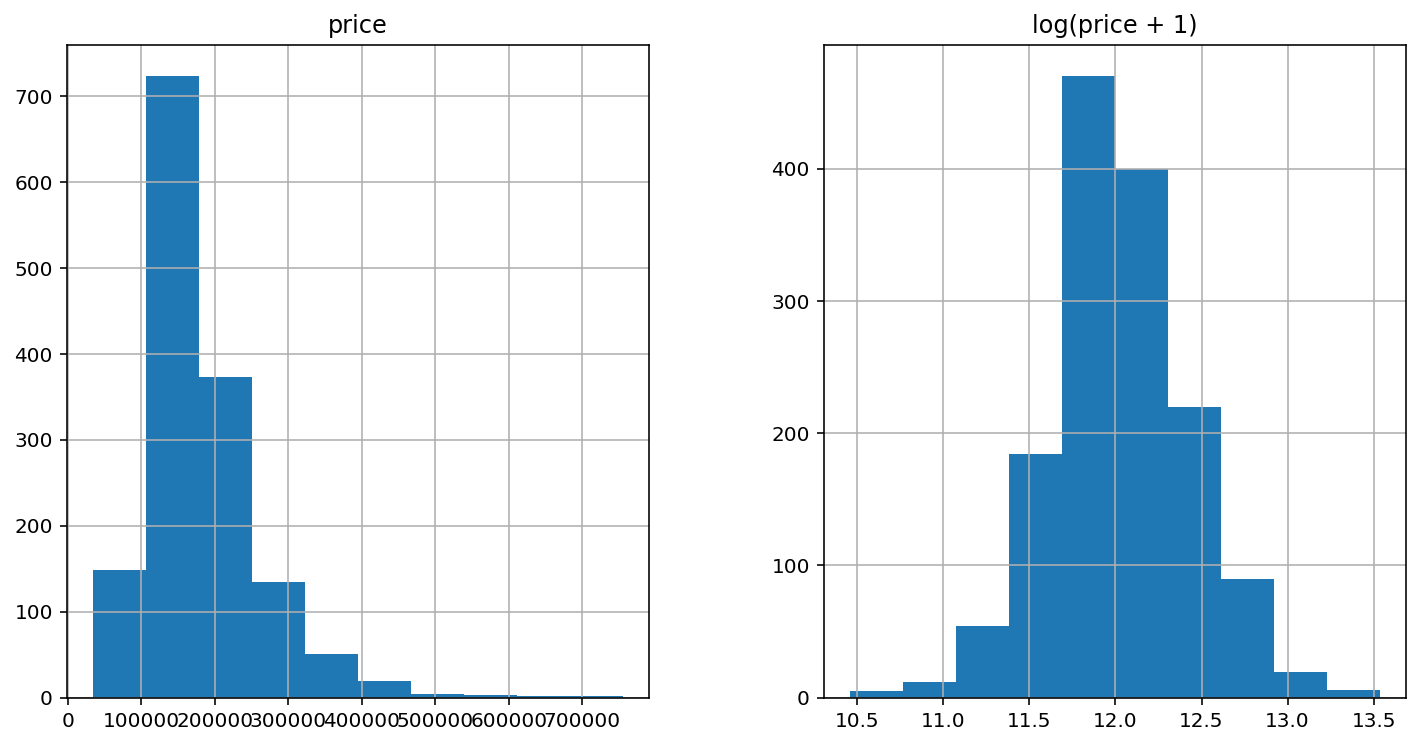

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [ ]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice


2021-11-14 02:19:15,811 INFO NumExpr defaulting to 2 threads.


**Models**

using regularized linear regression models from the scikit learn module

Text(0, 0.5, 'rmse')

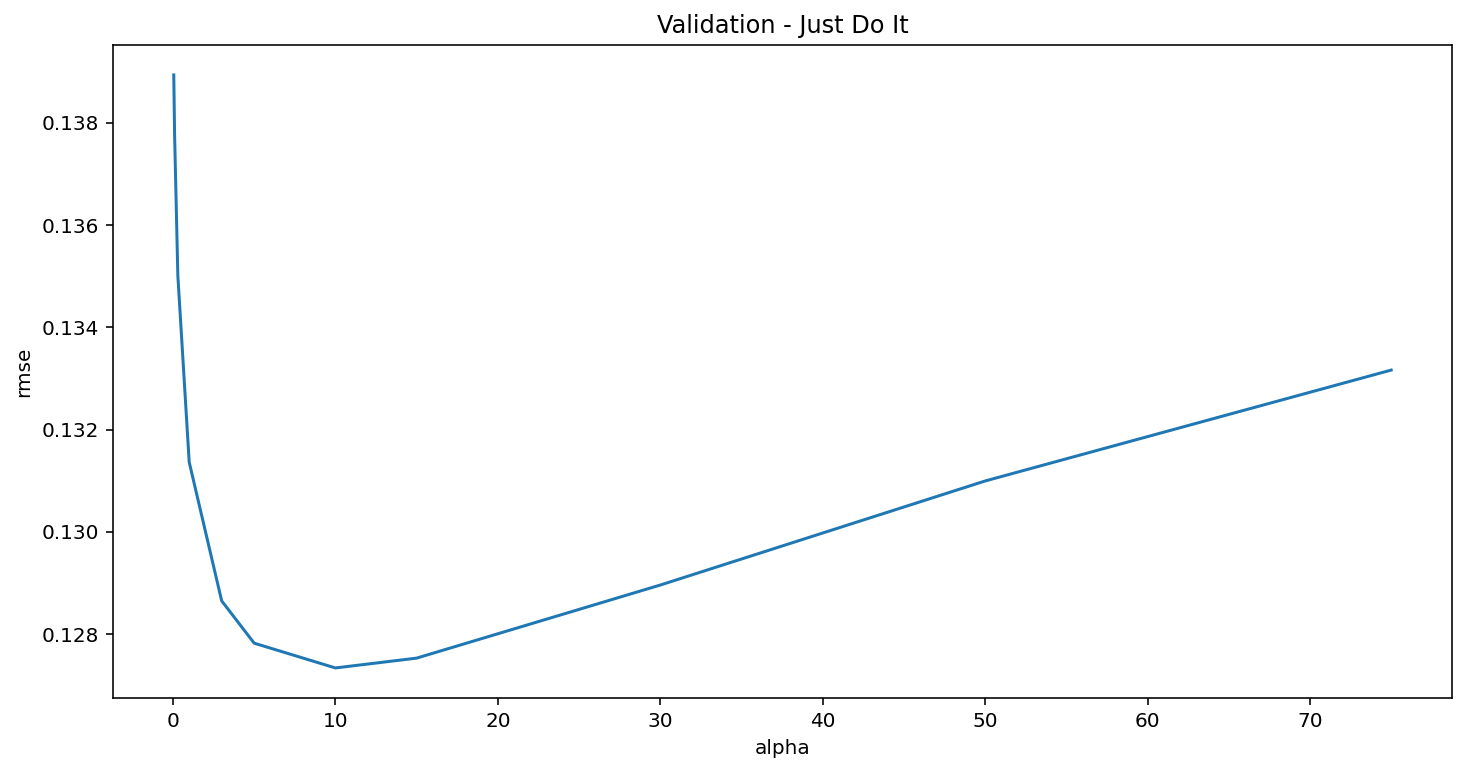

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

model_ridge = Ridge()

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")



In [ ]:
cv_ridge.min()

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

rmse_cv(model_lasso).mean()

coef = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

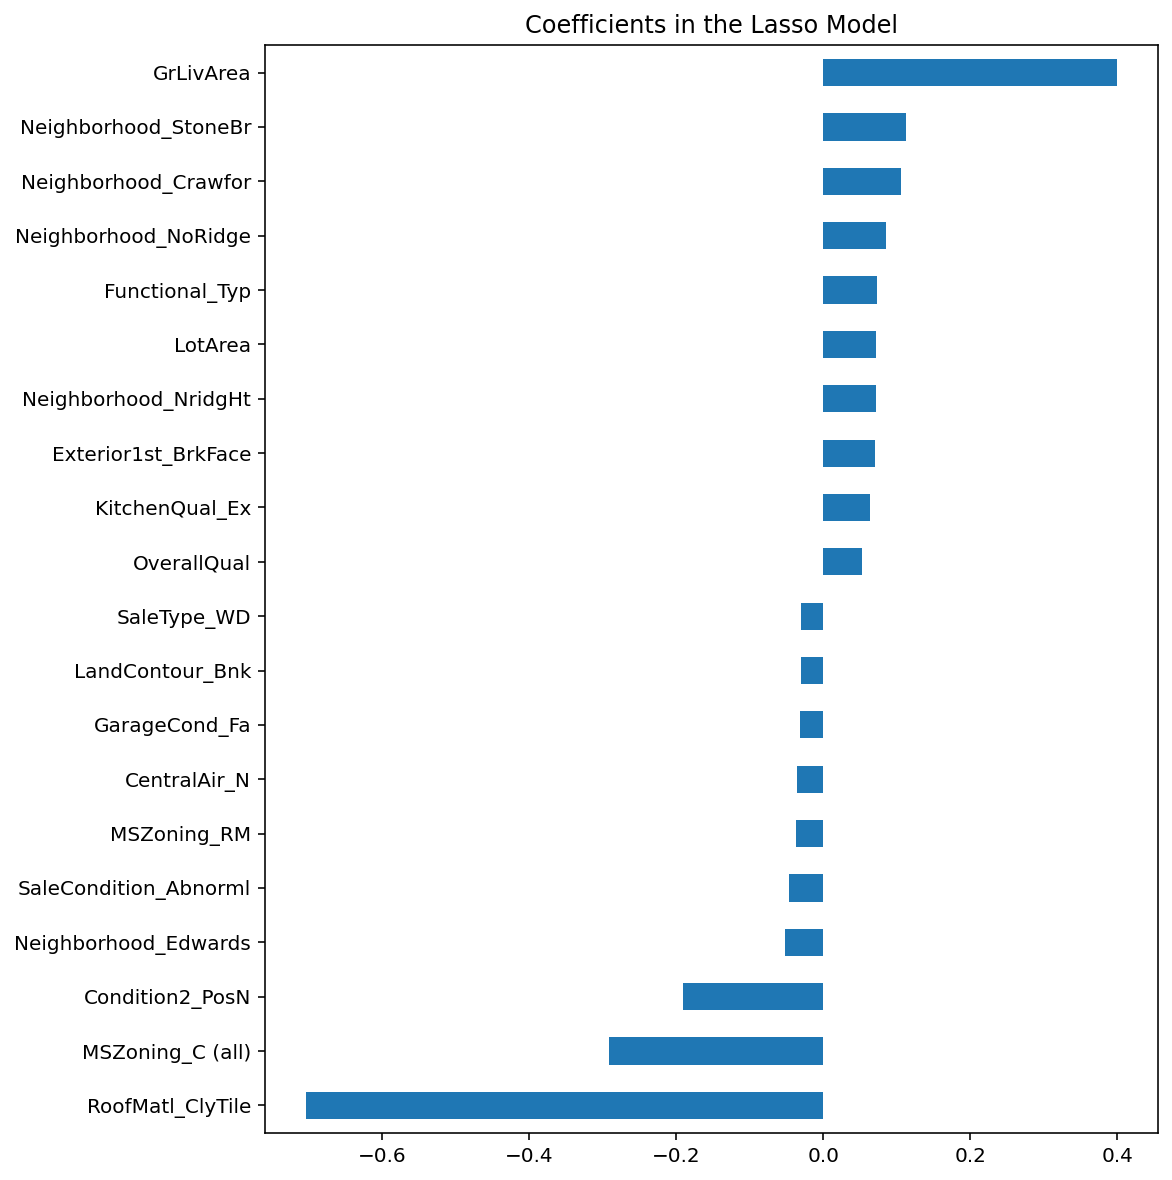

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

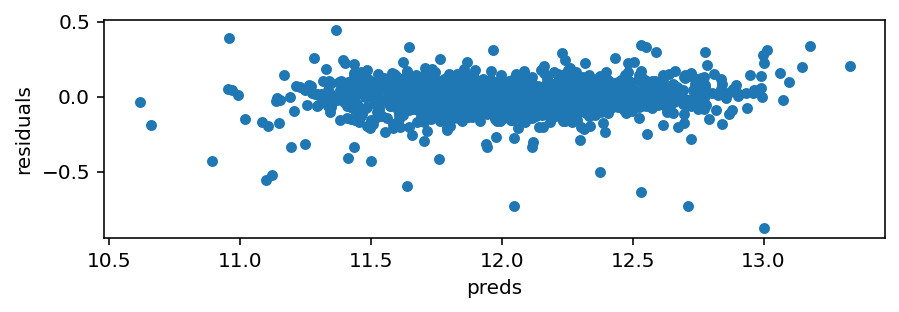

In [ ]:
matplotlib.rcParams['figure.figsize'] = (7.0, 2.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

**XGBOOST MODEL**

Adding an xgboost model

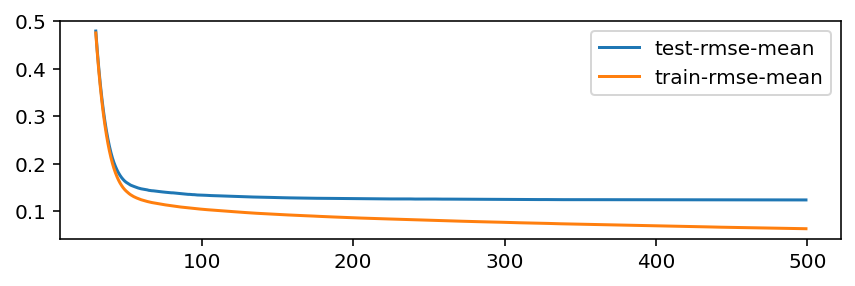

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

[02:21:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


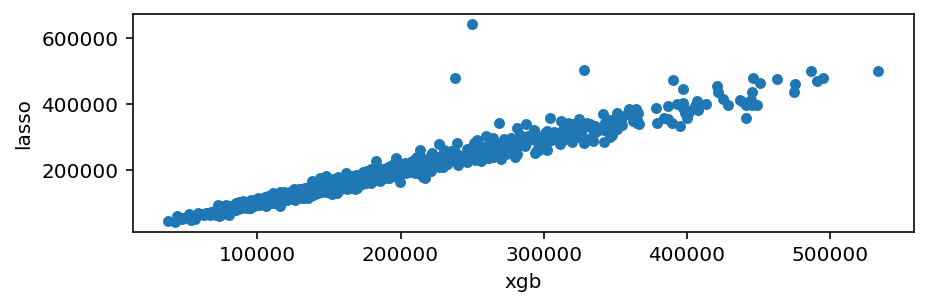

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

preds = 0.7*lasso_preds + 0.3*xgb_preds

solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

**KERAS**

In [ ]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train = StandardScaler().fit_transform(X_train)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)
X_tr.shape

X_tr

model = Sequential()


model.compile(loss = "mse", optimizer = "adam")

In [ ]:
model.summary()

hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

pd.Series(model.predict(X_val)[:,0]).hist()